In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/predict-pet-adoption-status-dataset/pet_adoption_data.csv


## Let's take a first look at the df

In [2]:
data = pd.read_csv('/kaggle/input/predict-pet-adoption-status-dataset/pet_adoption_data.csv')

data.head()

,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0
1,501,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0
2,502,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0
3,503,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0
4,504,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PetID               2007 non-null   int64  
 1   PetType             2007 non-null   object 
 2   Breed               2007 non-null   object 
 3   AgeMonths           2007 non-null   int64  
 4   Color               2007 non-null   object 
 5   Size                2007 non-null   object 
 6   WeightKg            2007 non-null   float64
 7   Vaccinated          2007 non-null   int64  
 8   HealthCondition     2007 non-null   int64  
 9   TimeInShelterDays   2007 non-null   int64  
 10  AdoptionFee         2007 non-null   int64  
 11  PreviousOwner       2007 non-null   int64  
 12  AdoptionLikelihood  2007 non-null   int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 204.0+ KB


In [4]:
data['AdoptionLikelihood'].value_counts()

AdoptionLikelihood
0    1348
1     659
Name: count, dtype: int64

## 659 likely to be adopted from a total of 2007, not so unbalanced (about 33%)

In [5]:
data['Breed'].value_counts()

Breed
Rabbit              493
Parakeet            487
Siamese             253
Persian             252
Labrador            193
Poodle              167
Golden Retriever    162
Name: count, dtype: int64

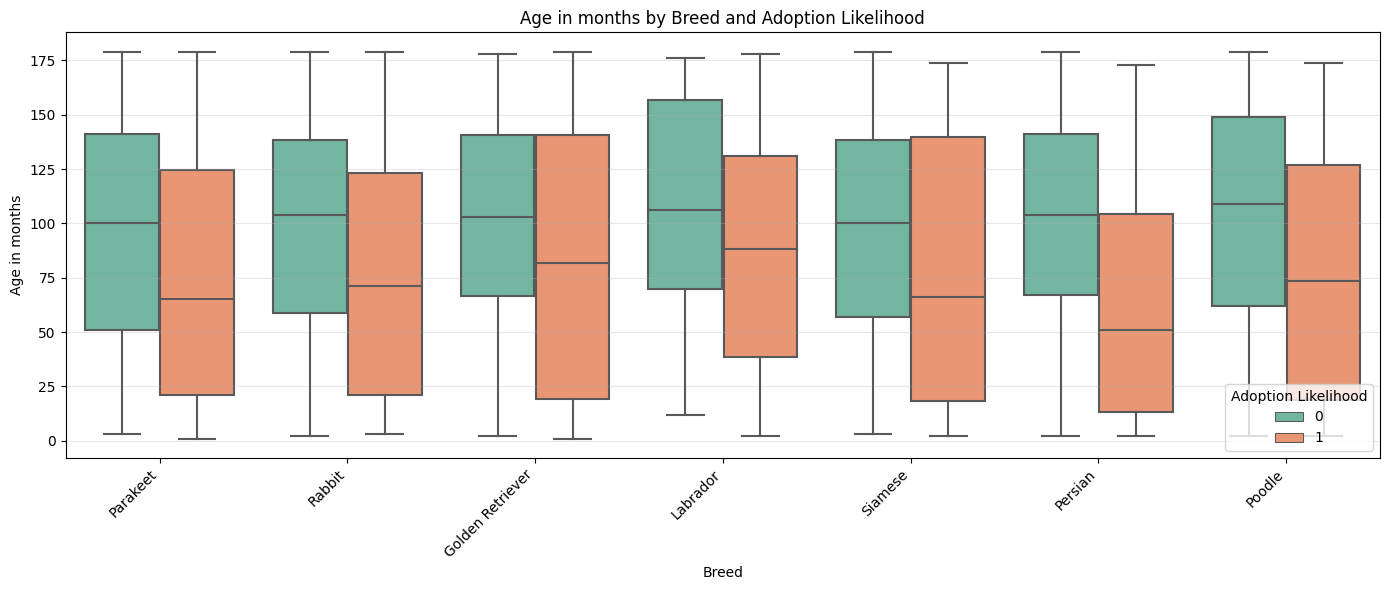

In [6]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=data,
    x='Breed',
    y='AgeMonths',
    hue='AdoptionLikelihood',
    palette='Set2'
)

plt.title("Age in months by Breed and Adoption Likelihood")
plt.xlabel("Breed")
plt.ylabel("Age in months")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Adoption Likelihood', loc='lower right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

## This shows there's a much higher chance of an animal to be adopted for younger animals, specially for persians.

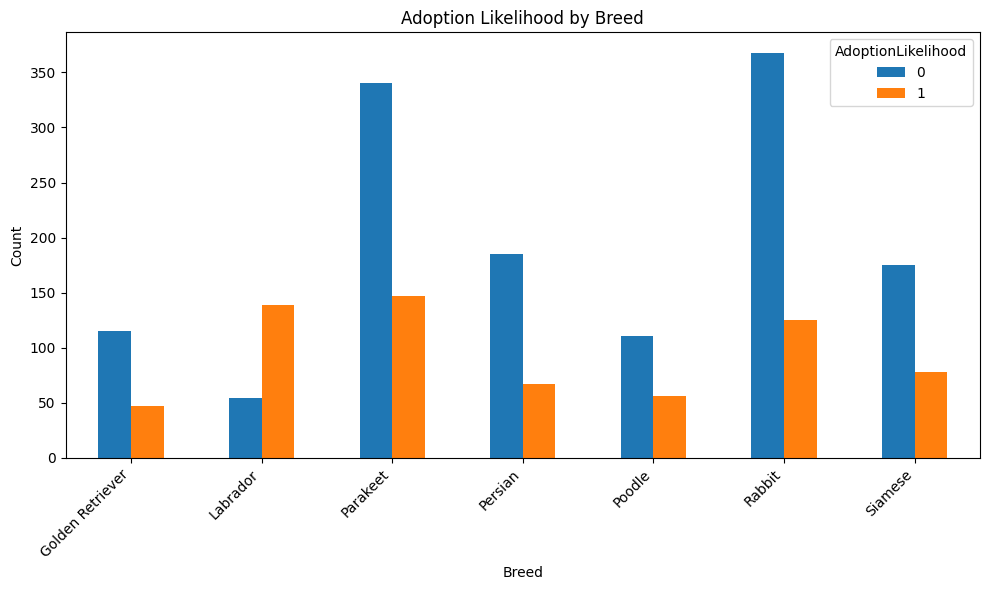

AdoptionLikelihood,Adoptable %
Breed,
Labrador,72.0%
Poodle,33.5%
Siamese,30.8%
Parakeet,30.2%
Golden Retriever,29.0%
Persian,26.6%
Rabbit,25.4%


In [7]:
grouped_data = data.groupby(['Breed', 'AdoptionLikelihood']).size().unstack(fill_value=0)

grouped_data.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Adoption Likelihood by Breed')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

grouped_data['Adoptable %'] = (
    grouped_data[1] / grouped_data.sum(axis=1) * 100
).round(1)

styled = grouped_data[['Adoptable %']].sort_values(by='Adoptable %', ascending=False).style \
    .set_caption("Adoption Likelihood by Breed (%)") \
    .format("{:.1f}%") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
    ]) \
    .background_gradient(cmap='Greens')

display(styled)

## Here we have a clearer view of the distribution of likelihood between breeds, with labradors being the highest chance of being adopted in their own groups. 

In [8]:
data['Vaccinated'] = data['Vaccinated'].astype(int)
data['AdoptionLikelihood'] = data['AdoptionLikelihood'].astype(int)

contingency_table = pd.crosstab(data['Vaccinated'], data['AdoptionLikelihood'])

print("Contingency Table (Counts):")
print("Rows: Vaccinated (0=No, 1=Yes)")
print("Columns: AdoptionLikelihood (0=Low/No, 1=High/Yes)")
print(contingency_table)

Contingency Table (Counts):
Rows: Vaccinated (0=No, 1=Yes)
Columns: AdoptionLikelihood (0=Low/No, 1=High/Yes)
AdoptionLikelihood    0    1
Vaccinated                  
0                   533   67
1                   815  592


## Here we have the correlation of vaccinated animals and the likelihood. Not all vaccinated animals get adopted, but there's a crushing number of vaccinated animals likely to be adopted than unvaccinated that are also likely. 

## From now on, it's better if we analyse each breed separately, as we'll have different insights depending on the breeds, since people might be interested differently. This was already suggested with the extremely high labrador likelihood

In [9]:
contingency_table = pd.crosstab(data['Vaccinated'], data['Breed'])

percent_row = (contingency_table.loc[1] / contingency_table.sum(axis=0) * 100).round(1)
percent_row.name = 'Vaccinated %'

contingency_table = pd.concat([contingency_table, pd.DataFrame([percent_row])])

# Estiliza a tabela
styled_table = contingency_table.style.set_caption("Contingency Table: Vaccination Status by Breed") \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('caption-side', 'top'),
                  ('font-size', '16px'),
                  ('font-weight', 'bold')]
    }]) \
    .format(na_rep='-', precision=1)

styled_table


Breed,Golden Retriever,Labrador,Parakeet,Persian,Poodle,Rabbit,Siamese
0,53.0,51.0,144.0,80.0,44.0,155.0,73.0
1,109.0,142.0,343.0,172.0,123.0,338.0,180.0
Vaccinated %,67.3,73.6,70.4,68.3,73.7,68.6,71.1


## Golden retrievers are the least vaccinated of the dogs, and also the least likely to be adopted from all. Maybe a correlation?

In [10]:
contingency_table = pd.crosstab(data['AdoptionLikelihood'], data['Breed'])

styled_table = contingency_table.style.set_caption("Contingency Table: Adoption Likelihood by Breed") \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('caption-side', 'top'),
                  ('font-size', '16px'),
                  ('font-weight', 'bold')]
    }]) \
    .format(na_rep='-')

styled_table


Breed,Golden Retriever,Labrador,Parakeet,Persian,Poodle,Rabbit,Siamese
AdoptionLikelihood,,,,,,,
0,115,54,340,185,111,368,175
1,47,139,147,67,56,125,78


In [11]:
breeds = data['Breed'].unique()

for breed in breeds:
    subset = data[data['Breed'] == breed]
    ct = pd.crosstab(subset['Vaccinated'], subset['AdoptionLikelihood'])

    styled = ct.style.set_caption(f"Contingency Table for Breed: {breed}") \
        .set_table_styles([
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
        ])

    display(styled)

AdoptionLikelihood,0,1
Vaccinated,,
0,134,10
1,206,137


AdoptionLikelihood,0,1
Vaccinated,,
0,145,10
1,223,115


AdoptionLikelihood,0,1
Vaccinated,,
0,48,5
1,67,42


AdoptionLikelihood,0,1
Vaccinated,,
0,31,20
1,23,119


AdoptionLikelihood,0,1
Vaccinated,,
0,64,9
1,111,69


AdoptionLikelihood,0,1
Vaccinated,,
0,73,7
1,112,60


AdoptionLikelihood,0,1
Vaccinated,,
0,38,6
1,73,50


## Checking these values, we can see that, clearly, being vaccinated is very important for the likelihood of being adopted. 

## Since this is health related, let's check for health conditions.

In [12]:
breeds = data['Breed'].unique()

for breed in breeds:
    subset = data[data['Breed'] == breed]
    ct = pd.crosstab(subset['AdoptionLikelihood'], subset['HealthCondition'])

    styled = ct.style.set_caption(f"Contingency Table for Breed: {breed}") \
        .set_table_styles([
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
        ])

    display(styled)

    print("% of likely to be adopted with health conditions: ", ((ct[1][1]/(ct[1][0] + ct[1][1]))*100).round(1))

HealthCondition,0,1
AdoptionLikelihood,,
0,257,83
1,143,4


% of likely to be adopted with health conditions:  4.6


HealthCondition,0,1
AdoptionLikelihood,,
0,278,90
1,119,6


% of likely to be adopted with health conditions:  6.2


HealthCondition,0,1
AdoptionLikelihood,,
0,91,24
1,42,5


% of likely to be adopted with health conditions:  17.2


HealthCondition,0,1
AdoptionLikelihood,,
0,31,23
1,129,10


% of likely to be adopted with health conditions:  30.3


HealthCondition,0,1
AdoptionLikelihood,,
0,124,51
1,74,4


% of likely to be adopted with health conditions:  7.3


HealthCondition,0,1
AdoptionLikelihood,,
0,131,54
1,65,2


% of likely to be adopted with health conditions:  3.6


HealthCondition,0,1
AdoptionLikelihood,,
0,80,31
1,49,7


% of likely to be adopted with health conditions:  18.4


## This shows that healthy animals are much more likely to be adopted than animals with health conditions, with labrador getting the better. This means that sick animals tend to be left in the shelter.

In [13]:
for breed in breeds:
    subset = data[data['Breed'] == breed]['TimeInShelterDays']
    
    print(f'Mean of days of {breed}: {subset.mean():.2f}')
    print(f'Median day of {breed}: {subset.median()}')


Mean of days of Parakeet: 43.33
Median day of Parakeet: 43.0
Mean of days of Rabbit: 45.42
Median day of Rabbit: 48.0
Mean of days of Golden Retriever: 45.59
Median day of Golden Retriever: 48.0
Mean of days of Labrador: 43.80
Median day of Labrador: 42.0
Mean of days of Siamese: 42.22
Median day of Siamese: 43.0
Mean of days of Persian: 43.65
Median day of Persian: 45.5
Mean of days of Poodle: 43.37
Median day of Poodle: 43.0


## The mean (chosen to check the group variancy) shows that all animals tend to have a similar time of being in the shelter, so let's check if there's a relation between being left in the shelter and the likeliness to be adopted

In [14]:
from scipy.stats import mannwhitneyu

for breed in breeds:
    subset = data[data['Breed'] == breed][['TimeInShelterDays', 'AdoptionLikelihood']]
    group0 = subset[subset['AdoptionLikelihood'] == 0]['TimeInShelterDays']
    group1 = subset[subset['AdoptionLikelihood'] == 1]['TimeInShelterDays']
    
    stat, p = mannwhitneyu(group0, group1)
    print(f"Mann-Whitney U test for {breed} = {stat:.2f}, p = {p:.4f}")

Mann-Whitney U test for Parakeet = 25164.50, p = 0.9028
Mann-Whitney U test for Rabbit = 21222.00, p = 0.1964
Mann-Whitney U test for Golden Retriever = 2666.00, p = 0.8943
Mann-Whitney U test for Labrador = 3545.50, p = 0.5523
Mann-Whitney U test for Siamese = 6103.50, p = 0.1797
Mann-Whitney U test for Persian = 6710.00, p = 0.3165
Mann-Whitney U test for Poodle = 3499.00, p = 0.1855


## The test suggests few correlation with the time on the shelter, however, we know that the greater the time on the shelter, the older the animal gets. Which influences our chances by influencing the Age feature. We can assume that it doesnt matter the time living in the shelter, as long as it's within a age range.

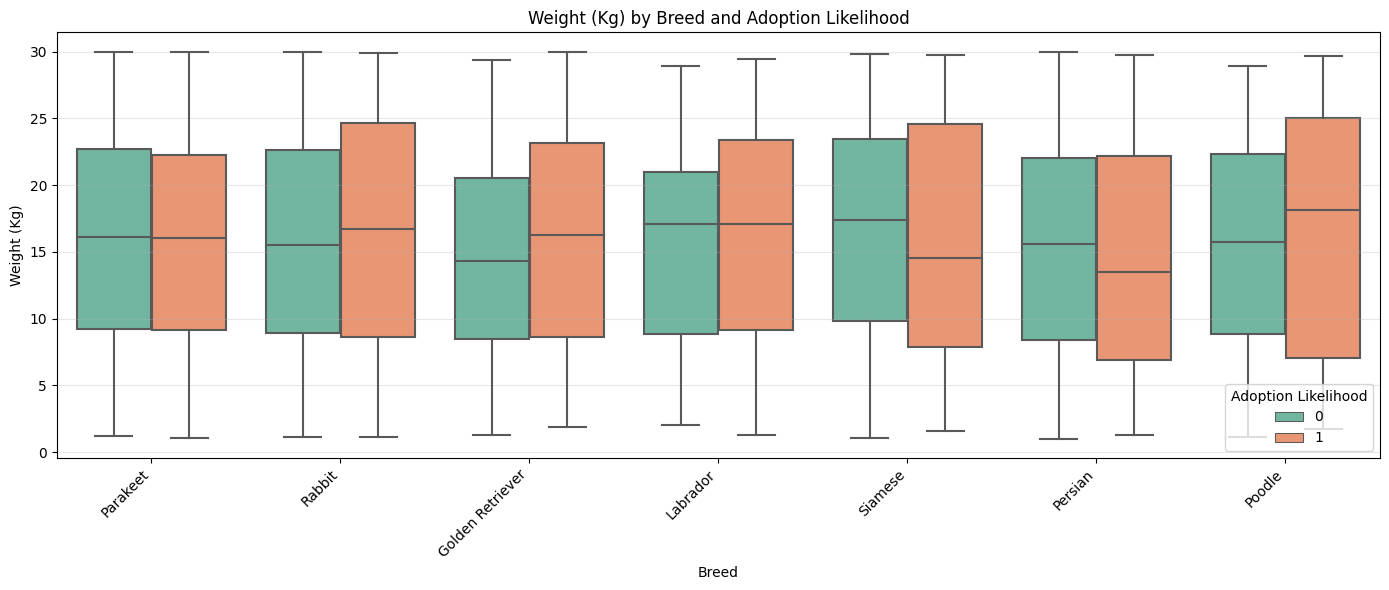

In [15]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=data,
    x='Breed',
    y='WeightKg',
    hue='AdoptionLikelihood',
    palette='Set2'
)

plt.title("Weight (Kg) by Breed and Adoption Likelihood")
plt.xlabel("Breed")
plt.ylabel("Weight (Kg)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Adoption Likelihood', loc='lower right')  # 👈 apenas isso
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()


## Close medians for some animals and distant for others. The weight matters more for some breeds. (Less for parakeets and labradors)

In [16]:
for breed in breeds:
    subset = data[data['Breed'] == breed]
    ct = pd.crosstab(subset['AdoptionLikelihood'], subset['Color'])

    ct_percent = ct.div(ct.sum(axis=1), axis=0)

    max_0 = ct_percent.loc[0].idxmax() if 0 in ct_percent.index else None
    max_1 = ct_percent.loc[1].idxmax() if 1 in ct_percent.index else None

    def highlight_max(s):
        return [
            'background-color: lightcoral' if s.name == 0 and col == max_0 else
            'background-color: lightgreen' if s.name == 1 and col == max_1 else
            ''
            for col in s.index
        ]

    styled = ct.style \
        .set_caption(f"Contingency Table for Breed: {breed}") \
        .set_table_styles([
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
        ]) \
        .apply(highlight_max, axis=1)

    display(styled)

Color,Black,Brown,Gray,Orange,White
AdoptionLikelihood,,,,,
0,62,69,64,74,71
1,26,23,34,38,26


Color,Black,Brown,Gray,Orange,White
AdoptionLikelihood,,,,,
0,56,76,78,68,90
1,29,29,24,23,20


Color,Black,Brown,Gray,Orange,White
AdoptionLikelihood,,,,,
0,22,18,27,18,30
1,12,7,11,6,11


Color,Black,Brown,Gray,Orange,White
AdoptionLikelihood,,,,,
0,10,6,13,15,10
1,29,30,28,29,23


Color,Black,Brown,Gray,Orange,White
AdoptionLikelihood,,,,,
0,40,34,28,37,36
1,21,14,9,18,16


Color,Black,Brown,Gray,Orange,White
AdoptionLikelihood,,,,,
0,42,35,34,37,37
1,11,14,15,16,11


Color,Black,Brown,Gray,Orange,White
AdoptionLikelihood,,,,,
0,28,20,19,18,26
1,7,8,16,12,13


## This table shows how the colors influence on adoption likelihood. It appears there's few correlation, it might not be so useful for our prediction model. 

In [17]:
breeds = data['Breed'].unique()

for breed in breeds:
    subset = data[data['Breed'] == breed]
    ct = pd.crosstab(subset['Size'], subset['AdoptionLikelihood'])

    styled = ct.style.set_caption(f"Contingency Table for Breed: {breed}") \
        .set_table_styles([
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
        ])

    display(styled)

AdoptionLikelihood,0,1
Size,,
Large,134,16
Medium,69,110
Small,137,21


AdoptionLikelihood,0,1
Size,,
Large,132,13
Medium,81,91
Small,155,21


AdoptionLikelihood,0,1
Size,,
Large,51,4
Medium,18,34
Small,46,9


AdoptionLikelihood,0,1
Size,,
Large,27,38
Medium,5,62
Small,22,39


AdoptionLikelihood,0,1
Size,,
Large,75,9
Medium,33,61
Small,67,8


AdoptionLikelihood,0,1
Size,,
Large,66,10
Medium,40,50
Small,79,7


AdoptionLikelihood,0,1
Size,,
Large,48,7
Medium,23,37
Small,40,12


## The size greatly impacts the chances, specially for medium animals always winning over other sizes.

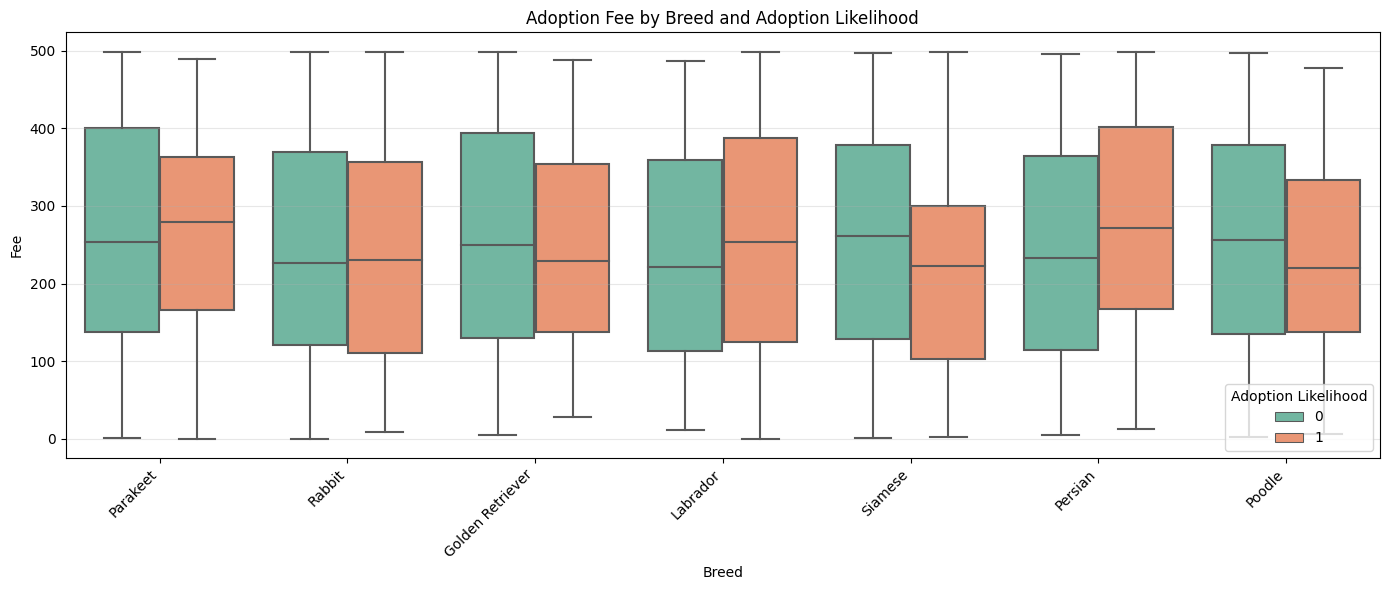

In [18]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=data,
    x='Breed',
    y='AdoptionFee',
    hue='AdoptionLikelihood',
    palette='Set2'
)

plt.title("Adoption Fee by Breed and Adoption Likelihood")
plt.xlabel("Breed")
plt.ylabel("Fee")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Adoption Likelihood', loc='lower right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

## AdoptionFee seems to not matter so much for the adoption, since we have higher medians on some breeds for likely to be adopted. 

In [19]:
breeds = data['Breed'].unique()

for breed in breeds:
    subset = data[data['Breed'] == breed]
    ct = pd.crosstab(subset['PreviousOwner'], subset['AdoptionLikelihood'])

    styled = ct.style.set_caption(f"Contingency Table for Breed: {breed}") \
        .set_table_styles([
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
        ])

    display(styled)

AdoptionLikelihood,0,1
PreviousOwner,,
0,236,104
1,104,43


AdoptionLikelihood,0,1
PreviousOwner,,
0,260,88
1,108,37


AdoptionLikelihood,0,1
PreviousOwner,,
0,79,37
1,36,10


AdoptionLikelihood,0,1
PreviousOwner,,
0,32,102
1,22,37


AdoptionLikelihood,0,1
PreviousOwner,,
0,116,52
1,59,26


AdoptionLikelihood,0,1
PreviousOwner,,
0,124,49
1,61,18


AdoptionLikelihood,0,1
PreviousOwner,,
0,84,38
1,27,18


## Preparing the dataset for cleanups and model production:

In [20]:
data = data.drop(columns = ['PetID'])

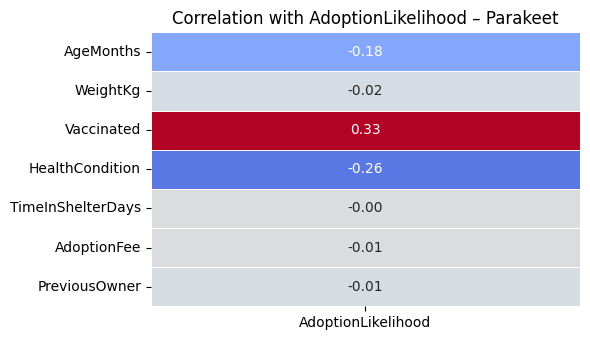

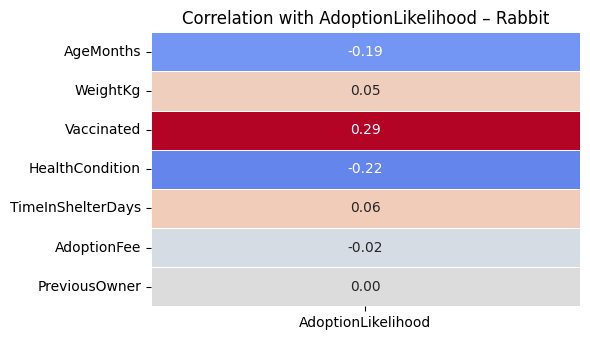

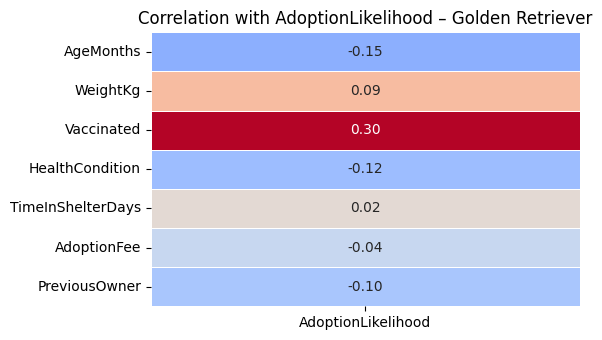

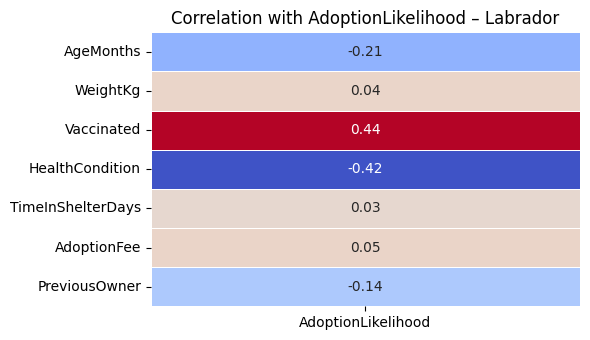

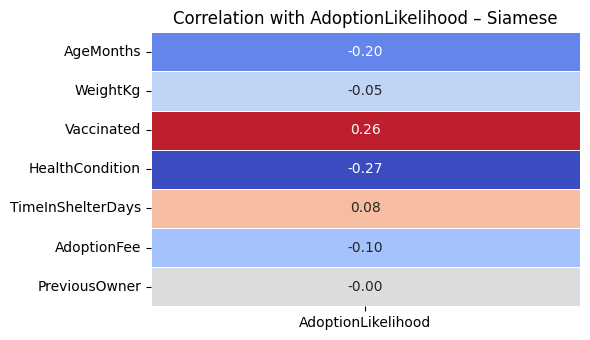

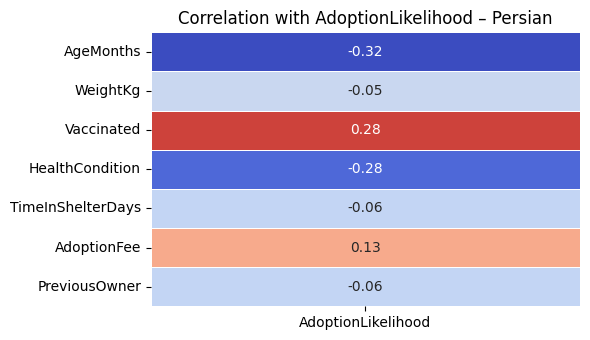

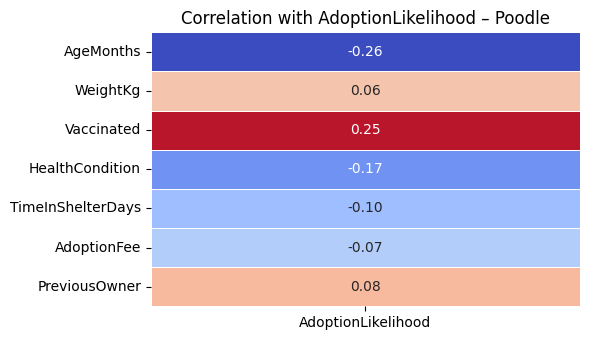

In [21]:
numerics = data.select_dtypes(include='number').drop(columns='AdoptionLikelihood').columns
breeds = data['Breed'].unique()

for breed in breeds:
    subset = data[data['Breed'] == breed]

    subset_corr = subset[numerics.tolist() + ['AdoptionLikelihood']]
    
    corr = subset_corr.corr()['AdoptionLikelihood'].drop('AdoptionLikelihood').to_frame()

    plt.figure(figsize=(6, len(corr) * 0.5))
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar=False
    )

    plt.title(f"Correlation with AdoptionLikelihood – {breed}")
    plt.tight_layout()
    plt.show()


## Let's start checking numerical columns, we know: 

### It's better if the animal is younger
### Having a previous owner mattered more for poodles
### Being vaccinated and not having any health conditions increases the likelihood to be adopted
### As expected, few correlation for time in shelter


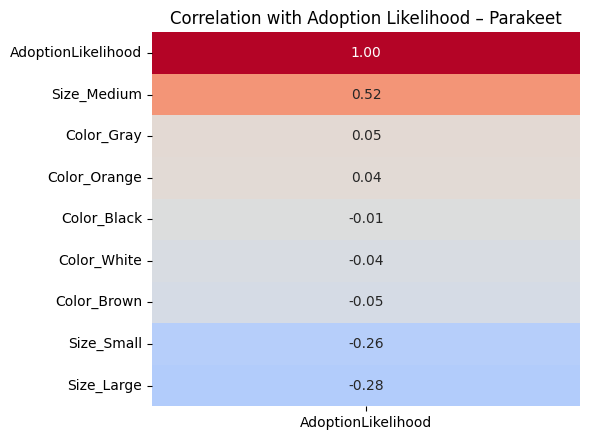

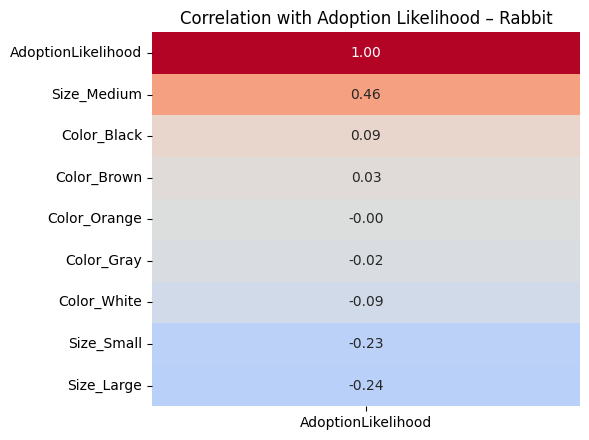

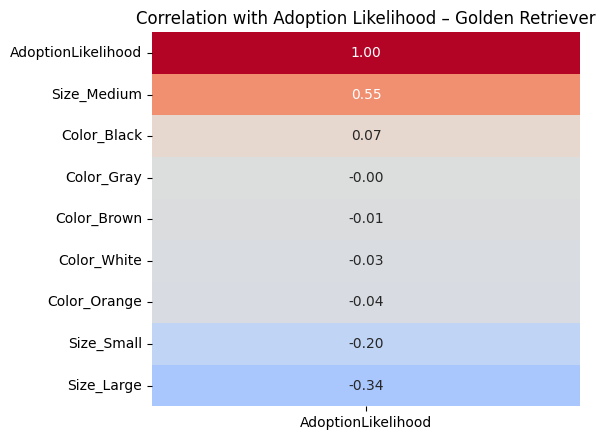

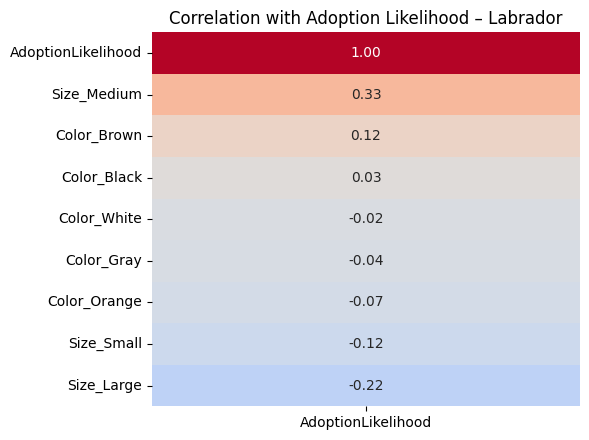

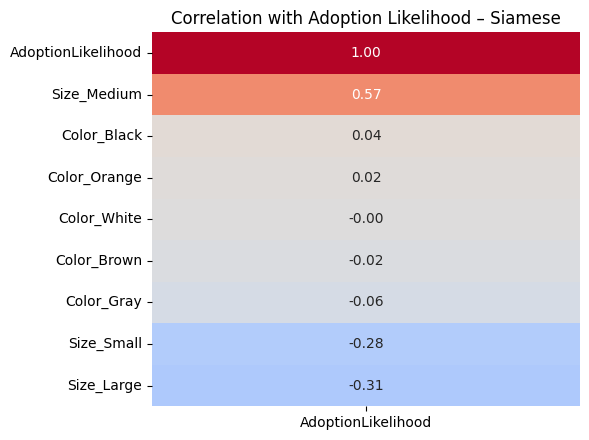

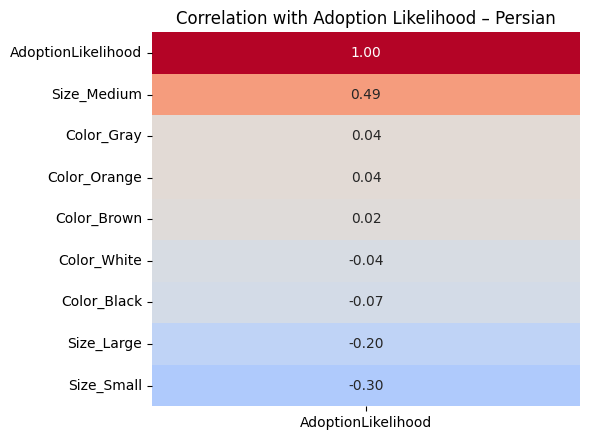

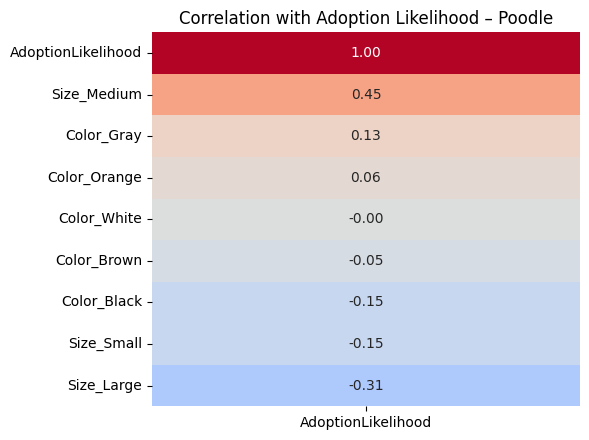

In [22]:
for breed in data['Breed'].unique():
    subset = data[data['Breed'] == breed]

    if len(subset) < 5:
        continue

    categoricals = subset[['Color', 'Size', 'AdoptionLikelihood']]

    dummies = pd.get_dummies(categoricals.drop(columns='AdoptionLikelihood'), drop_first=False)

    corr_data = pd.concat([dummies, categoricals['AdoptionLikelihood']], axis=1)

    corr = corr_data.corr()
    corr_target = corr[['AdoptionLikelihood']].sort_values(by='AdoptionLikelihood', ascending=False)

    plt.figure(figsize=(6, len(corr_target) / 2))
    sns.heatmap(
        corr_target,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        cbar=False
    )

    plt.title(f"Correlation with Adoption Likelihood – {breed}")
    plt.tight_layout()
    plt.show()


## For the categorical columns, we know:

### Larger animals are less likely to be adopted than small animals
### How the colors influence are quite distributed, but with low influence as expected. However we know that it's better for poodles, persians and parakeets to be gray, for golden retrievers to be black (odd for a GOLDEN retriever). 


In [23]:
train_df = data[['Breed', 'AgeMonths', 'Color','Size', 'WeightKg', 'Vaccinated', 'HealthCondition', 'TimeInShelterDays','AdoptionFee','PreviousOwner','AdoptionLikelihood']]

train_encoded = pd.get_dummies(train_df, columns=['Size', 'Breed', 'Color'], drop_first=False)

train_encoded.head()

,AgeMonths,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood,Size_Large,Size_Medium,...,Breed_Parakeet,Breed_Persian,Breed_Poodle,Breed_Rabbit,Breed_Siamese,Color_Black,Color_Brown,Color_Gray,Color_Orange,Color_White
0,131,5.039768,1,0,27,140,0,0,True,False,...,True,False,False,False,False,False,False,False,True,False
1,73,16.086727,0,0,8,235,0,0,True,False,...,False,False,False,True,False,False,False,False,False,True
2,136,2.076286,0,0,85,385,0,0,False,True,...,False,False,False,False,False,False,False,False,True,False
3,97,3.339423,0,0,61,217,1,0,False,False,...,True,False,False,False,False,False,False,False,False,True
4,123,20.498100,0,0,28,14,1,0,True,False,...,False,False,False,True,False,False,False,True,False,False


## Lets just choose all columns. We have lots of categorical columns, so a random forest might go well.

In [24]:
X = train_encoded.drop(columns = ['AdoptionLikelihood'])
y = train_encoded['AdoptionLikelihood']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

rand_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)

rand_forest.fit(X_train, y_train)

y_pred = rand_forest.predict(X_test)


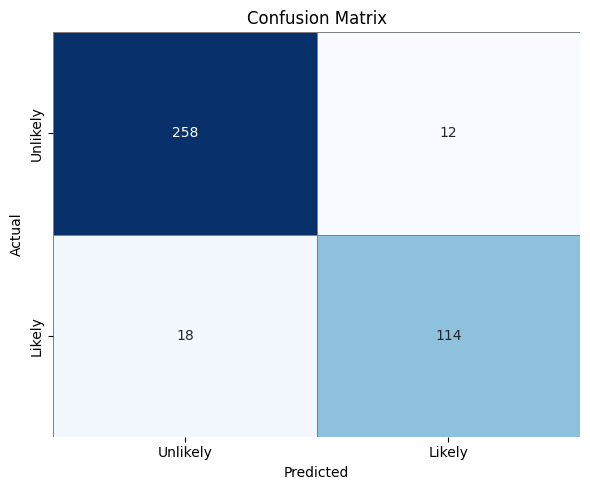

Accuracy : 0.9254
Precision: 0.9048
Recall   : 0.8636
F1-score : 0.8837


In [25]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Unlikely', 'Likely']

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Métricas principais
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


## Outstanding perfomance! We scored greater than 85% on all metrics. Let's check the AUC ROC curve and maybe we can go deeper on perfomance. 

AUC-ROC: 0.9071


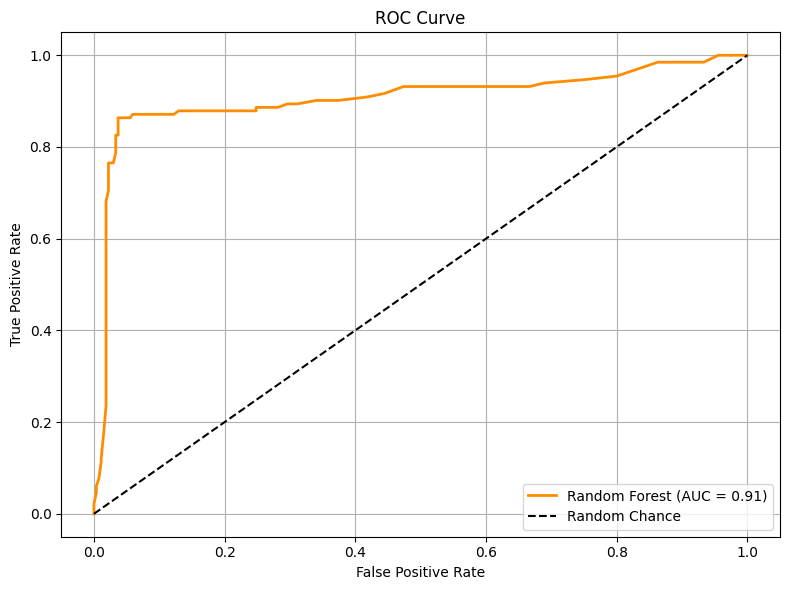

In [26]:
y_probs = rand_forest.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.2f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## We hit a score of 0.91, which is great already. Let's check how the score changes with feature importances.

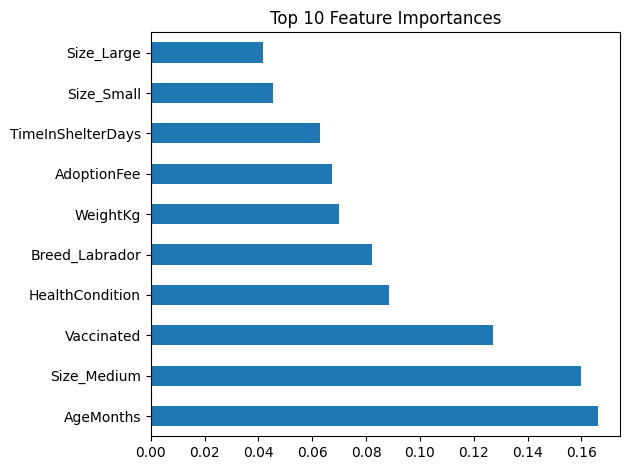

In [27]:
feat_importances = pd.Series(rand_forest.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

## Now, we can confirm some of our assumptions: the age of the animal matters the most, as well as being medium sized, healthy and... a labrador! However, the adoption fee had a greater importance than thought. No colors appear on the top 10 features. 

In [28]:
for i in range(1, len(train_encoded.columns.tolist())):
    top_features = feat_importances.sort_values(ascending=False).head(i).index
    X_top = X[top_features]
    
    rf_top = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_top.fit(X_train[top_features], y_train)
    
    y_probs_top = rf_top.predict_proba(X_test[top_features])[:, 1]
    auc_top = roc_auc_score(y_test, y_probs_top)
    print(f"AUC com top {i} features: {auc_top:.4f}")


AUC com top 1 features: 0.5841
AUC com top 2 features: 0.7480
AUC com top 3 features: 0.8214
AUC com top 4 features: 0.8767
AUC com top 5 features: 0.9126
AUC com top 6 features: 0.9087
AUC com top 7 features: 0.9124
AUC com top 8 features: 0.9072
AUC com top 9 features: 0.9069
AUC com top 10 features: 0.9045
AUC com top 11 features: 0.9046
AUC com top 12 features: 0.9170
AUC com top 13 features: 0.9119
AUC com top 14 features: 0.9081
AUC com top 15 features: 0.9070
AUC com top 16 features: 0.9062
AUC com top 17 features: 0.9073
AUC com top 18 features: 0.9073
AUC com top 19 features: 0.9074
AUC com top 20 features: 0.9072
AUC com top 21 features: 0.9113
AUC com top 22 features: 0.9075


## The highest perfomance seems to be at top 12 features. Let's check them.

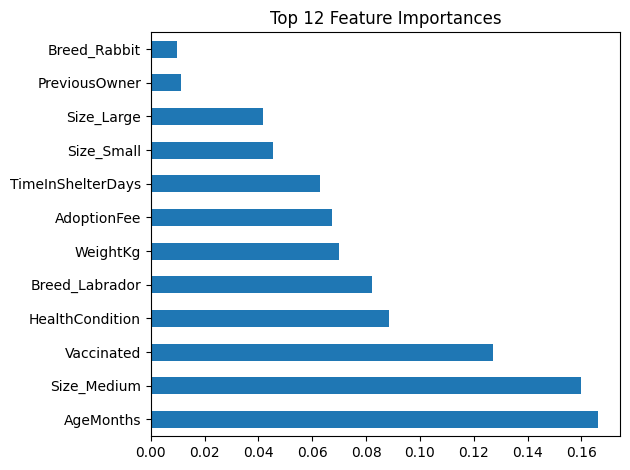

In [29]:
feat_importances.nlargest(12).plot(kind='barh')
plt.title("Top 12 Feature Importances")
plt.tight_layout()
plt.show()